<a href="https://colab.research.google.com/github/MuhammadZadaRizki/TubesDL_FaceRecognition/blob/main/ResNet_18_FaceRecognitionipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
##Residual Network (ResNet)

# He et. al. 2015

### Persiapan & Instalasi

!pip install scikit-learn

In [4]:
# Load semua library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import timm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

# Library tambahan
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import glob
from google.colab import drive
drive.mount('/content/drive')

# Konfigurasi Device
print("PyTorch version:", torch.__version__)
print("timm version:", timm.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Mounted at /content/drive
PyTorch version: 2.9.0+cu126
timm version: 1.0.22
Using device: cpu


In [5]:
# Set random seed untuk hasil yang konsisten
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [6]:
# Fungsi bantuan untuk visualisasi (imshow)
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# --- Fungsi untuk Training dan Evaluasi ---
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    pbar = tqdm(dataloader, desc="Training")
    for images, targets in pbar:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total_correct += preds.eq(targets).sum().item()
        total_samples += targets.size(0)
        pbar.set_postfix(loss=total_loss/total_samples, acc=100*total_correct/total_samples)

    return total_loss / total_samples, total_correct / total_samples

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating")
        for images, targets in pbar:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total_correct += preds.eq(targets).sum().item()
            total_samples += targets.size(0)
            pbar.set_postfix(val_loss=total_loss/total_samples, val_acc=100*total_correct/total_samples)

    return total_loss / total_samples, total_correct / total_samples

In [7]:
# Persiapan dataset

# lokasi root dataset
data_root = '/content/drive/MyDrive/FaceRecognition'

img_size = 224
batch_size = 32

# Import necessary classes for image validation
from PIL import Image
from PIL import UnidentifiedImageError

# Custom function to validate image files
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()  # Verify image integrity
        return True
    except (IOError, SyntaxError, UnidentifiedImageError) as e:
        print(f"Skipping corrupt or unidentifiable image: {path} - Error: {e}")
        return False

# gambar di-resize.
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ds = torchvision.datasets.ImageFolder(root=os.path.join(data_root,'Train'), transform=train_transform, is_valid_file=is_valid_image)
val_ds = torchvision.datasets.ImageFolder(root=os.path.join(data_root,'Train'), transform=val_transform, is_valid_file=is_valid_image)

# Memeriksa jumlah kelas yang terdeteksi
num_classes = len(train_ds.classes)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# Mengambil nama-nama kelas yang terdeteksi secara otomatis
classes = train_ds.classes
print(f"Dataset berhasil dimuat. Total Kelas (Orang): {num_classes}")
print("Contoh Nama Kelas yang Terdeteksi:", classes[:5])

Skipping corrupt or unidentifiable image: /content/drive/MyDrive/FaceRecognition/Train/Joshia Fernandes Sectio Purba/.DS_Store - Error: cannot identify image file '/content/drive/MyDrive/FaceRecognition/Train/Joshia Fernandes Sectio Purba/.DS_Store'
Skipping corrupt or unidentifiable image: /content/drive/MyDrive/FaceRecognition/Train/Lois Novel E Gurning/foto 3 - LOIS NOVEL E. GURNING.jpg - Error: cannot identify image file '/content/drive/MyDrive/FaceRecognition/Train/Lois Novel E Gurning/foto 3 - LOIS NOVEL E. GURNING.jpg'
Skipping corrupt or unidentifiable image: /content/drive/MyDrive/FaceRecognition/Train/Lois Novel E Gurning/foto 4 - LOIS NOVEL E. GURNING.jpg - Error: cannot identify image file '/content/drive/MyDrive/FaceRecognition/Train/Lois Novel E Gurning/foto 4 - LOIS NOVEL E. GURNING.jpg'
Skipping corrupt or unidentifiable image: /content/drive/MyDrive/FaceRecognition/Train/Martua Kevin A.M.H.Lubis/IMG_20241208_223409_653 - MARTUA KEVIN ANDREAS MUAL H LUBIS.jpg - Error: c

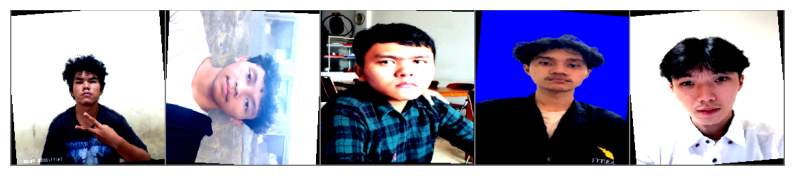

Labels: ['Bezalel Samuel Manik', 'Joshua Palti Sinaga', 'Joyapul Hanscalvin Panjaitan', 'hayyatul fajri', 'Kenneth Austin Wijaya']


In [8]:
# Visualisasi contoh data
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:5].cpu()))
print('Labels:', [classes[labels[j]] for j in range(5)])

In [9]:
# 🧠 Inisialisasi dari library timm

model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model.to(device)

print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [10]:
# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

In [11]:
# 🎓 Proses training
num_epochs = 5  # 5 epoch
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")


Epoch 1/5


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Acc: 0.73% | Val Acc: 2.55%

Epoch 2/5


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x793a44031e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x793a44031e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Acc: 1.82% | Val Acc: 5.45%

Epoch 3/5


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Acc: 5.45% | Val Acc: 8.36%

Epoch 4/5


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Acc: 6.18% | Val Acc: 9.45%

Epoch 5/5


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x793a44031e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Acc: 6.18% | Val Acc: 9.82%


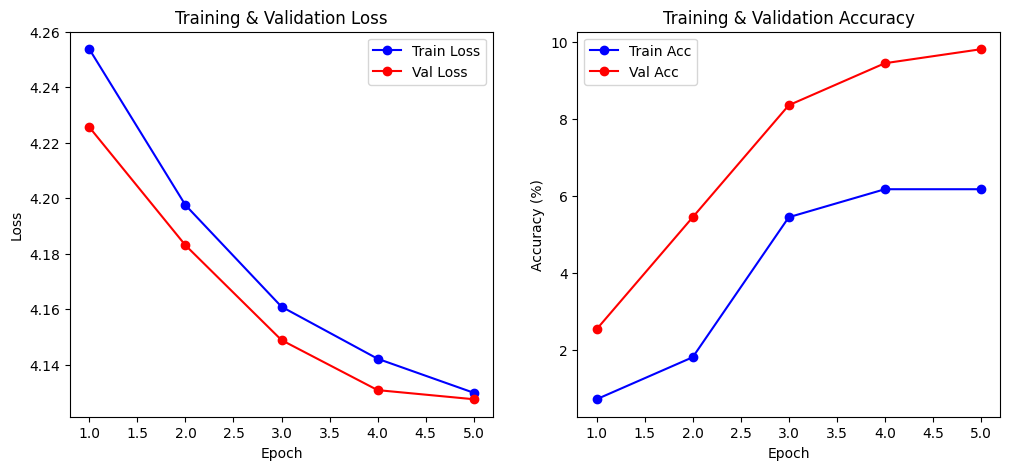

In [12]:
# 📈 Visualisasi hasil training
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
plt.plot(epochs, val_losses, 'r-o', label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, [a*100 for a in train_accs], 'b-o', label='Train Acc')
plt.plot(epochs, [a*100 for a in val_accs], 'r-o', label='Val Acc')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

Overall Test Accuracy Akhir: **9.82%**


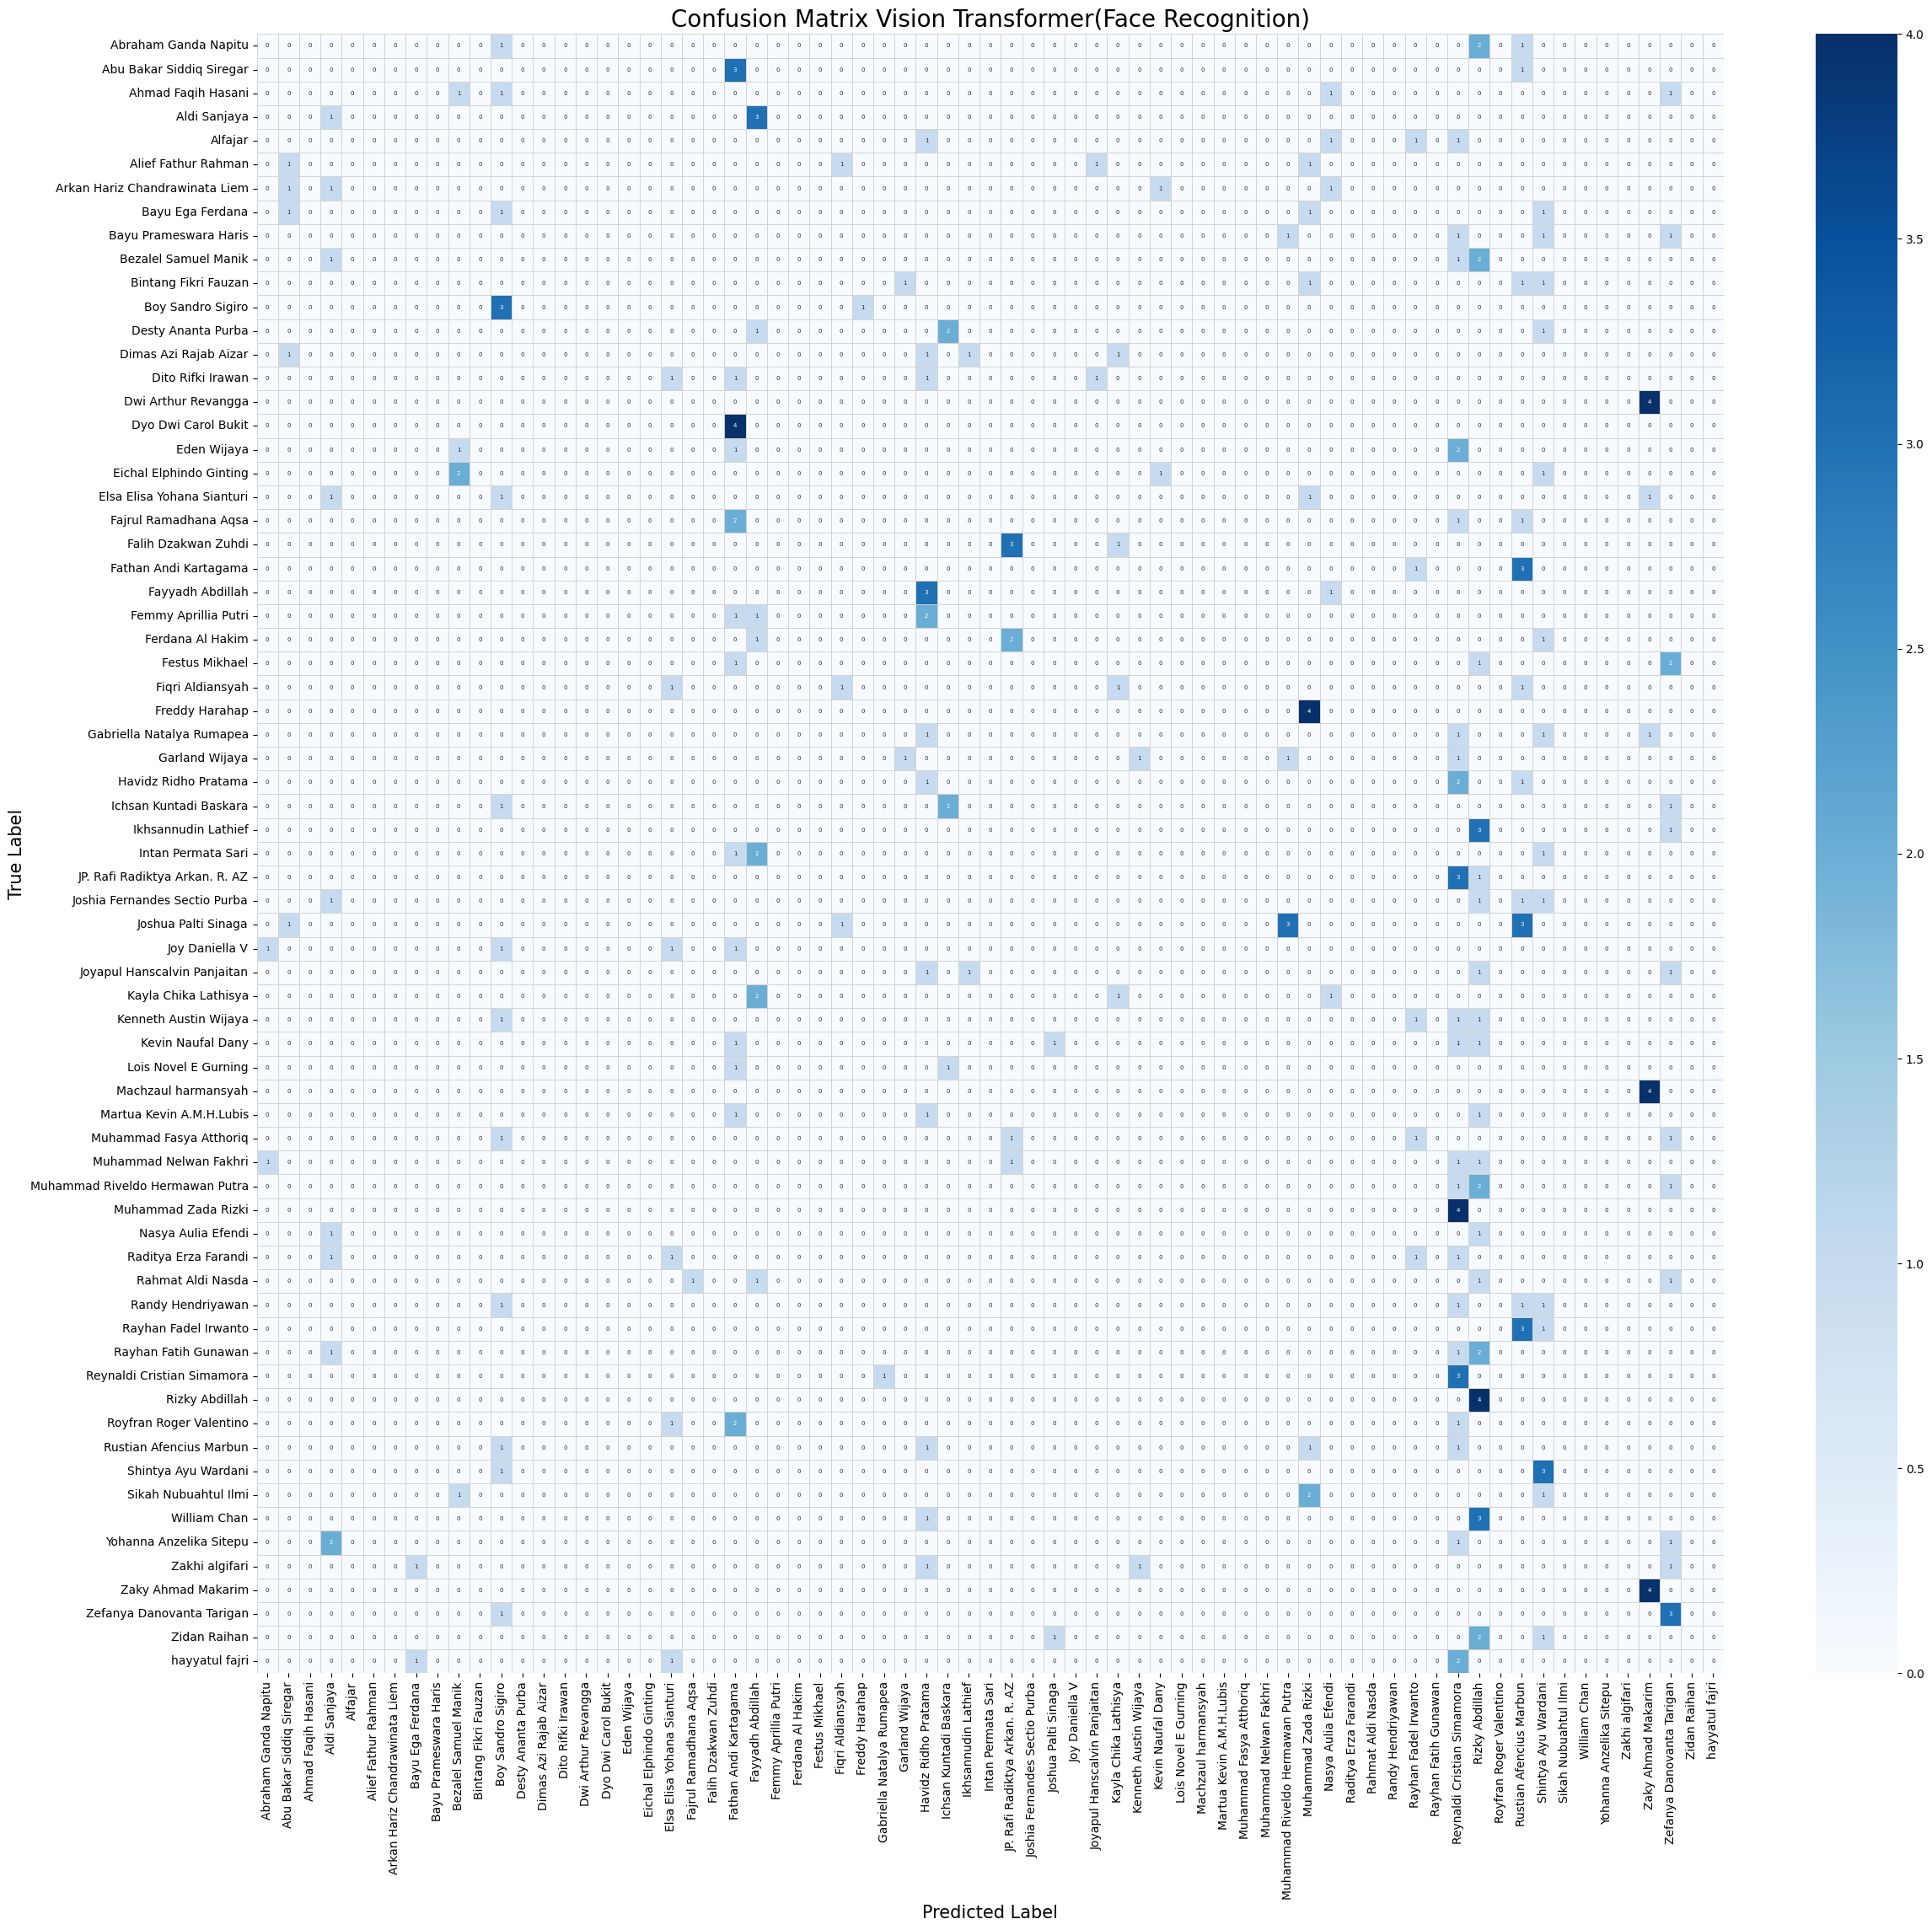

In [13]:
# --- Implementasi Metrik Performa & Confusion Matrix ---
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Collecting Predictions for Metrics"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Hitung Akurasi Keseluruhan (Overall Accuracy)
overall_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"Overall Test Accuracy Akhir: **{overall_acc*100:.2f}%**")

# Confusion Matrix (Visualisasi)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(25, 23))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            linewidths=.5, # Menambah garis antar sel agar lebih jelas
            linecolor='lightgray', # Warna garis
            annot_kws={"size": 5})
plt.title('Confusion Matrix Vision Transformer(Face Recognition)', fontsize=20)
plt.ylabel('True Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.xticks(rotation=90, fontsize=10) # Rotasi label X dan ukuran font
plt.yticks(rotation=0, fontsize=10)  # Rotasi label Y dan ukuran font
plt.tight_layout() # Mengatur layout agar tidak tumpang tindih
plt.show()

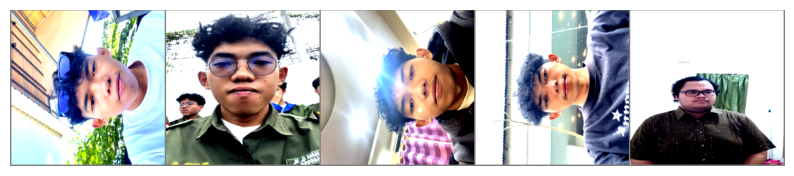

Ground Truth : ['Abraham Ganda Napitu', 'Abraham Ganda Napitu', 'Abraham Ganda Napitu', 'Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar']
Predictions  : ['Rustian Afencius Marbun', 'Rizky Abdillah', 'Boy Sandro Sigiro', 'Rizky Abdillah', 'Rustian Afencius Marbun']


In [14]:
# Evaluasi model akhir dan tampilkan prediksi sampel
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:5].cpu()))
print("Ground Truth :", [classes[labels[j]] for j in range(5)])
print("Predictions  :", [classes[preds[j]] for j in range(5)])

In [15]:
# Simpan model hasil training

path_folder = "/content/drive/MyDrive/FaceRecognition/SavedModel/"
if not os.path.exists(path_folder):
  os.makedirs(path_folder)
torch.save(model.state_dict(), "/content/drive/MyDrive/FaceRecognition/SavedModel/ResNet18_model.pth")
print("\n✅ Model disimpan")


✅ Model disimpan
